This code only works when direction == 'UD' for now

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
from scipy.ndimage import gaussian_filter
import os
%matplotlib inline

In [2]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

# load files 

In [3]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
# direction = 'UD'

# SVDnSTK = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\STK.mat'
#                   , squeeze_me =True)
# RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat'
#                   , squeeze_me =True)

loadfiles = np.load(exp_folder+'\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)

In [4]:
# RFprop = RFprop['RF_properties']

In [5]:
# STK = SVDnSTK['gauss_RF']

In [6]:
cn = 9

In [7]:
ExpData = loadmat(exp_folder+'merge\\merge_0224_Checkerboard_30Hz_27_15min_Br50_Q100_re', squeeze_me =True)

# cal STK from exp. data

In [8]:
checkerboard = ExpData['bin_pos']
fs = 1.5
GFcheckerboard = np.array([gaussian_filter(cb.astype(float), fs) for cb in checkerboard])
GFCcheckerboard = GFcheckerboard - np.mean(GFcheckerboard, axis = 0)
dt = 1/60
rstate, _ = np.histogram(ExpData['reconstruct_spikes'][cn-1], np.arange(len(checkerboard)+1)*dt)
Taxis = np.arange(60)*dt

In [9]:
dt=1/60 #large dt will cause  overflow
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]
TKAS = NGD2L_TK_AS(Taxis, *pd.DataFrame(para_dict).loc[cn-1][:-1])

In [10]:
STK = np.zeros([60,27,27])
for i in range(60): #1s
    for ii in np.arange(0, len(checkerboard)-i):
        STK[i,:,:] += rstate[ii+i]*GFCcheckerboard[ii,:,:]
    STK[i,:,:] /= np.sum(rstate[:len(checkerboard)-i])

# plot STK

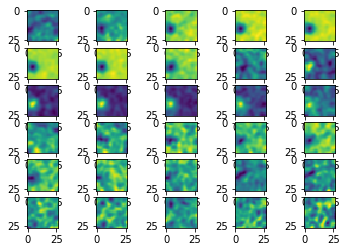

In [11]:
fig, ax = plt.subplots(6,5)
for i in range(30):
    ax.flatten()[i].imshow(STK[i,:,:])

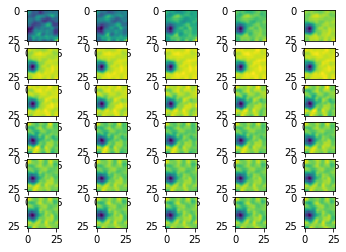

In [12]:
fig, ax = plt.subplots(6,5)
for i in range(30):
    ax.flatten()[i].imshow(np.sum(STK[:i+1,:,:], axis = 0))

# SVD

In [13]:
rSTK = STK.reshape((-1,27*27))
U,sigma,VT=np.linalg.svd(rSTK)

In [14]:
(sigma/np.sum(sigma))[:5]

array([0.2044324 , 0.04267267, 0.03869833, 0.03538358, 0.03426009])

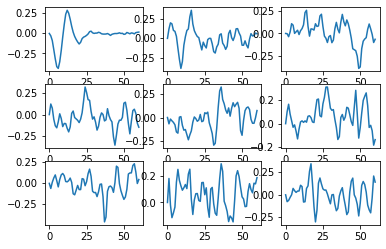

In [15]:
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax.flatten()[i].plot(np.append(0,U[:,i]))

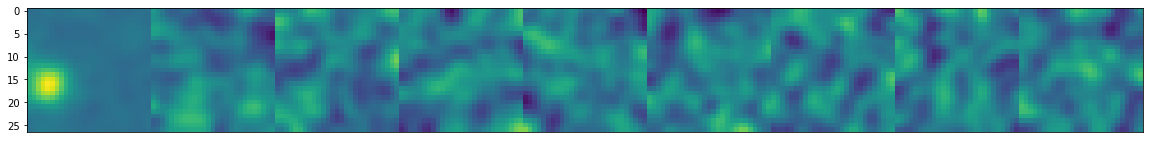

In [16]:
VTtogather=VT[0,:].reshape((27,27))
for i in np.arange(1,9):
    VTtogather = np.hstack((VTtogather, VT[i,:].reshape((27,27))))
plt.imshow(VTtogather)
plt.gca().axes.xaxis.set_visible(False)
plt.gcf().set_size_inches(20, 3)

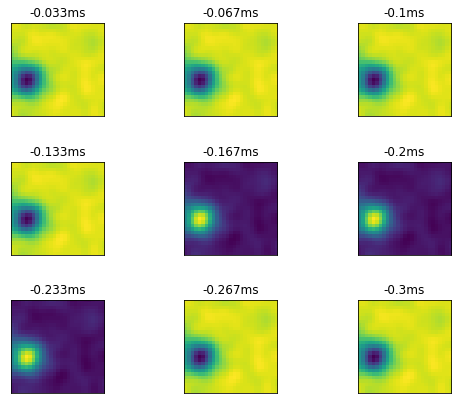

In [17]:
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax.flatten()[i].imshow(VT[0,:].reshape((27,27)) * U[(i+1)*2,0])
    ax.flatten()[i].set_title(str(-1*np.round((i+1)/30, 3))+'ms')
    ax.flatten()[i].axes.xaxis.set_visible(False)
    ax.flatten()[i].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.set_size_inches(8,6)

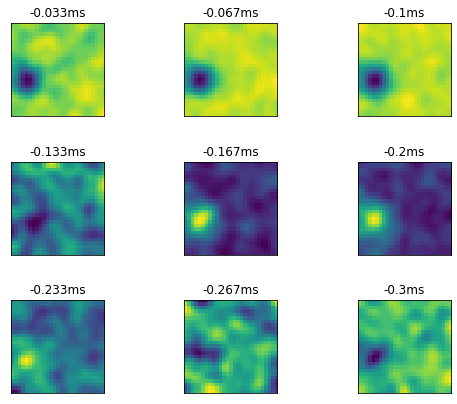

In [18]:
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax.flatten()[i].imshow(STK[(i+1)*2,:,:])
    ax.flatten()[i].set_title(str(-1*np.round((i+1)/30, 3))+'ms')
    ax.flatten()[i].axes.xaxis.set_visible(False)
    ax.flatten()[i].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.set_size_inches(8,6)

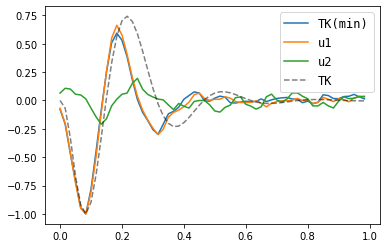

In [19]:
argminTK = STK[:, np.where(STK == np.min(STK))[1] ,np.where(STK == np.min(STK))[2]]
plt.plot(Taxis, argminTK/-min(argminTK) , label='TK(min)')
plt.plot(Taxis, U[:,0] /-min(U[:,0]) , label='u1')
plt.plot(Taxis, U[:,1] /-min(U[:,1])*sigma[1]/sigma[0], label='u2')
plt.plot(Taxis, TKAS/-min(TKAS), 'k--', label = 'TK', alpha = 0.5)

plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

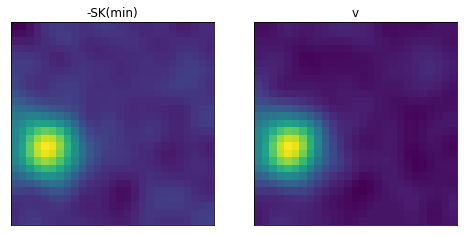

In [20]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(-STK[np.where(STK == np.min(STK))[0],:,:]))
ax[0].set_title('-SK(min)')
ax[1].imshow(VT[0,:].reshape((27,27)))
ax[1].set_title('v')
for a in ax:
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)
fig.set_size_inches(8,6)

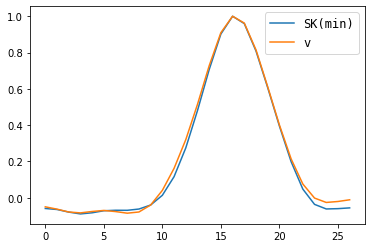

In [21]:
argminSKcut = np.squeeze(STK[np.where(STK == np.min(STK))[0], :, np.where(STK == np.min(STK))[2]])
plt.plot(argminSKcut/ min(argminSKcut), label='SK(min)')
v = VT[0,:].reshape((27,27))
vcut = v[:, np.where(STK == np.min(STK))[2]]
plt.plot(vcut/ max(vcut), label='v')


plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

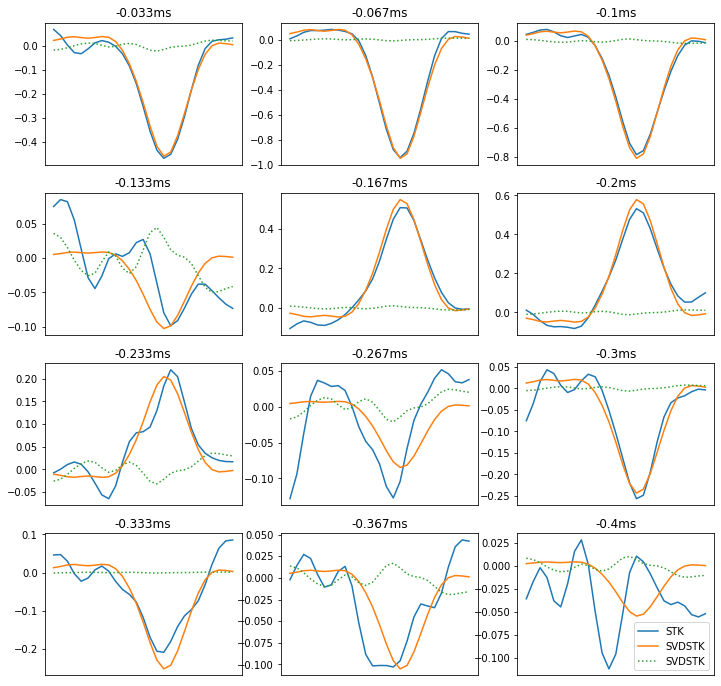

In [22]:
fig, ax = plt.subplots(4,3)
v = VT[0,:].reshape((27,27))
vcut = v[:, np.where(STK == np.min(STK))[2]]

v1 = VT[1,:].reshape((27,27))
v1cut = v1[:, np.where(STK == np.min(STK))[2]]
for i in range(12):
    argminSKcut = np.squeeze(STK[(i+1)*2, :, np.where(STK == np.min(STK))[2]])
    ax.flatten()[i].plot(-argminSKcut/np.min(STK), label='STK')
    ax.flatten()[i].plot(-vcut*U[(i+1)*2,0]/max(vcut)/min(U[:,0]), label='SVDSTK')
    
    ax.flatten()[i].plot(-v1cut*U[(i+1)*2,1]/max(vcut)/min(U[:,0])*sigma[1]/sigma[0], ':',label='SVDSTK')
    
    ax.flatten()[i].set_title(str(-1*np.round((i+1)/30, 3))+'ms')
#     ax.flatten()[i].set_ylim([-1, -1*max(U[:,0])/min(U[:,0])+0.1])
    ax.flatten()[i].axes.xaxis.set_visible(False)
ax.flatten()[-1].legend(loc='best')
    
    
# fig.tight_layout()
fig.set_size_inches(12,12)